### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 21 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 21 декабря, -4 балла после 08:30 28 декабря, -6 баллов после 08:30 04 янва, -8 баллов после 08:30 11 января.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

1) $$ L(a(x_i), y_i) = (y_i - a(x_i))^2
\\-\frac{\partial L}{\partial a(x_i)} = 2(y_i - a(x_i)) $$

2) $$ L(a(x_i), y_i) = exp(-a(x_i)y_i)
\\-\frac{\partial L}{\partial a(x_i)} = y_i exp(-a(x_i)y_i) $$

3) $$ L(a(x_i), y_i) = log(1 + exp(-a(x_i)y_i))
\\-\frac{\partial L}{\partial a(x_i)} = \frac{y_i exp(-a(x_i)y_i)}{1 + exp(-a(x_i)y_i)} $$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [138]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [149]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.3, n_estimators=6, 
                 colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучении одного алгоритма
        subsample -- процент рандомных объектов при обучении одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        
        self._loss = loss
        self._learning_rate = learning_rate
        self._n_estimators = n_estimators
        self._colsample = colsample
        self._subsample = subsample
        self._args = args
        self._kwargs = kwargs
        self._init_model = None        # начальная модель ансамбля
        self._init_md_features = None  # номера фичей начальной модели
        self._base_models = []         # базовые модели ансамбля
        self._base_md_features = []    # номера фичей базовых моделей
        self._is_classifier = False
        
    def __antigradient(self, a, y):
        """
        Вычисляет антиградиент функции потерь
        (на i-м объекте или векторе объектов).
        a - предсказание бустинга на i-м объекте или на векторе объектов,
        y - таргет i-го объекта или вектор таргетов
        """
        
        antigradients = {
            'mse': lambda a, y: 2 * (y - a),
            'exponential': lambda a, y: y * np.exp(-a * y),
            'logit': lambda a, y: y * np.exp(-a * y) / (1 + np.exp(-a * y))
        }
        
        return antigradients[self._loss](a, y)
    
    def make_sample(self, X, y):
        """
        Выбирает рандомные self.colsample фичей и self.subsample случайных объектов
        и возвращает их номера
        """

        nrows = X.shape[0]
        ncols = X.shape[1]
        rowsize = np.around(nrows * self._subsample).astype(int)
        colsize = np.around(ncols * self._colsample).astype(int)
        row_indices = np.random.choice(nrows, size=rowsize, replace=True)
        col_indices = np.random.choice(ncols, size=colsize, replace=True)
        
        X_sample = X[np.ix_(row_indices, col_indices)]
        y_sample = y[row_indices]
        
        return row_indices, col_indices
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        
        self._init_model = None
        self._init_md_features = None
        self._base_models = []
        self._base_md_features = []
        self._is_classifier = False
        
        if y.dtype in (np.dtype('int8'), np.dtype('int16'), 
                       np.dtype('int32'), np.dtype('int64')):
            self._is_classifier = True
        
        if init_model is not None:
            objects, features = self.make_sample(X, y)
            X_sample = X[np.ix_(objects, features)]
            y_sample = y[objects]
            init_md = init_model()
            init_md.fit(X_sample, y_sample)
            self._init_model = init_md
            self._init_md_features = features
        
        for _ in range(self._n_estimators):
            objects, features = self.make_sample(X, y)
            X_sample = X[objects, :]
            y_sample = y[objects]
            antigradient = self.__antigradient(self.__iteration_predict(X_sample), y_sample)
            base_md = base_model(*self._args, **self._kwargs)
            X_sample = X_sample[:, features]
            base_md.fit(X_sample, antigradient)
            self._base_models.append(base_md)
            self._base_md_features.append(features)
            
        self._base_md_features = np.asarray(self._base_md_features)
            
    def __iteration_predict(self, X):
        lr = self._learning_rate
            
        prediction = lr * sum([
            base_md.predict(X[:, features])
            for base_md, features in zip(self._base_models, self._base_md_features)
        ])
        
        init_md = self._init_model
        features = self._init_md_features
        
        if init_md is not None:
            prediction += init_md.predict(X[:, features])
            
        return prediction
    
    def predict(self, X):
        # Ваш код здесь
        
        prediction = self.__iteration_predict(X)
        
        if self._is_classifier:
            prediction = np.around(prediction).astype(int)
            
        return prediction

In [23]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [8]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [26]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [79]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [80]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


Подберем следующие оптимальные параметры (для небольшого числа деревьев):
- learning_rate
- оптимальную глубину дерева (max_depth)
- оптимальное число объектов в листах (min_samples_leaf)
- оптимальное число объектов для сплита (min_samples_split)
- процент рандомных фичей при обучении одного алгоритма (colsample)
- процент рандомных объектов при обучении одного алгоритма (subsample)

In [131]:
def cross_val_score(n_splits=5, *args, **kwargs):
    my_clf = MyGradientBoostingClassifier(*args, **kwargs)
    kf = KFold(n_splits=n_splits)
    
    scores = []
    
    for train_indices, test_indices in kf.split(X):
        X_train, X_test = X[train_indices, :], X[test_indices, :]
        y_train, y_test = y[train_indices], y[test_indices]
        my_clf.fit(X_train, y_train)
        scores.append(accuracy_score(y_pred=my_clf.predict(X_test), 
                                     y_true=y_test))
    scores = np.asarray(scores)
    
    return scores

In [132]:
opt_params = {'n_estimators': 10}

def find_opt_param(param_name, param_range, known_params=opt_params):
    mean_scores = []

    for param in tqdm(param_range):
        kwargs = known_params
        kwargs.update({param_name: param})
        scores = cross_val_score(**kwargs)
        mean_scores.append(scores.mean())

    opt_param = param_range[np.argmax(mean_scores)]

    plt.figure(figsize=(10, 6))
    plt.xlabel(param_name)
    plt.ylabel('score')
    plt.title(f'Зависимость средней точности от параметра {param_name}, кросс-валидация.\n'
              f'Оптимальное значение параметра {param_name}: {opt_param}')
    plt.plot(param_range, mean_scores)
    
    return opt_param

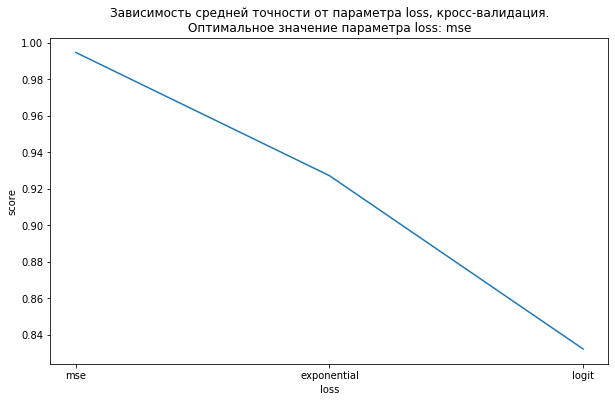

In [160]:
loss_range = ['mse', 'exponential', 'logit']
opt_loss = find_opt_param('loss', loss_range)
opt_params.update({'loss': opt_loss})

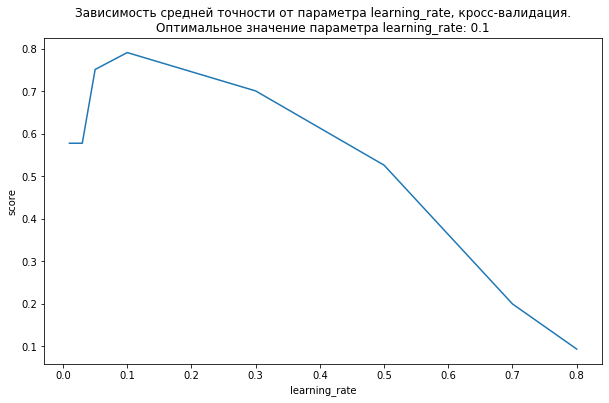

In [133]:
lr_range = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 0.8]
opt_lr = find_opt_param('learning_rate', lr_range)
opt_params.update({'learning_rate': opt_lr})

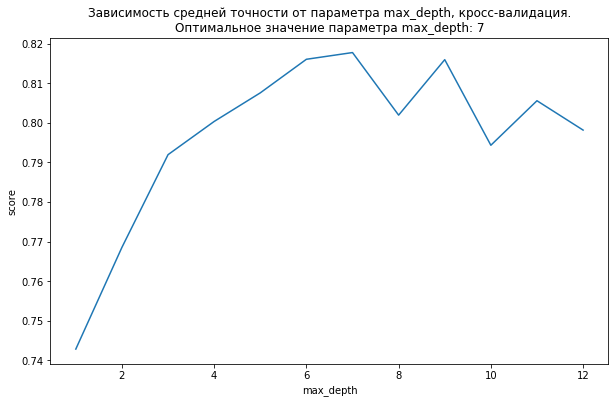

In [119]:
max_depth_range = range(1, 13)
opt_max_depth = find_opt_param('max_depth', max_depth_range)
opt_params.update({'max_depth': opt_max_depth})

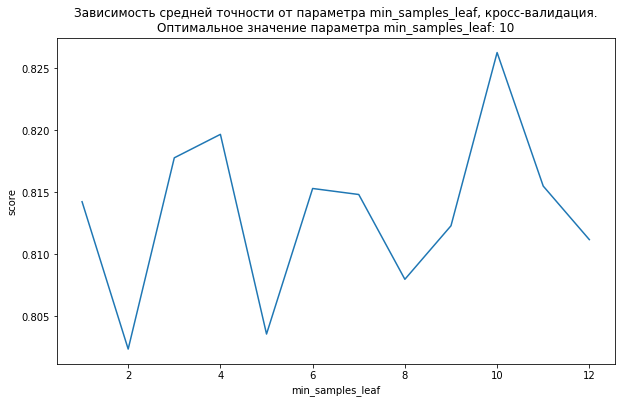

In [120]:
min_samples_leaf_range = range(1, 13)
opt_min_samples_leaf = find_opt_param('min_samples_leaf', min_samples_leaf_range)
opt_params.update({'min_samples_leaf': opt_min_samples_leaf})

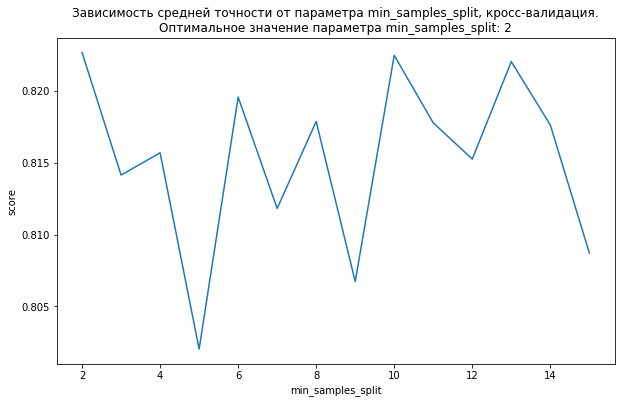

In [124]:
min_samples_split_range = range(2, 16)
opt_min_samples_split = find_opt_param('min_samples_split', min_samples_split_range)
opt_params.update({'min_samples_split': opt_min_samples_split})

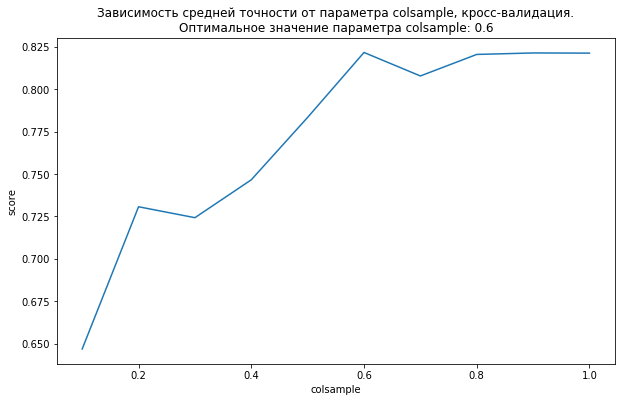

In [128]:
colsample_range = np.arange(0.1, 1.1, 0.1)
opt_colsample = find_opt_param('colsample', colsample_range)
opt_params.update({'colsample': opt_colsample})

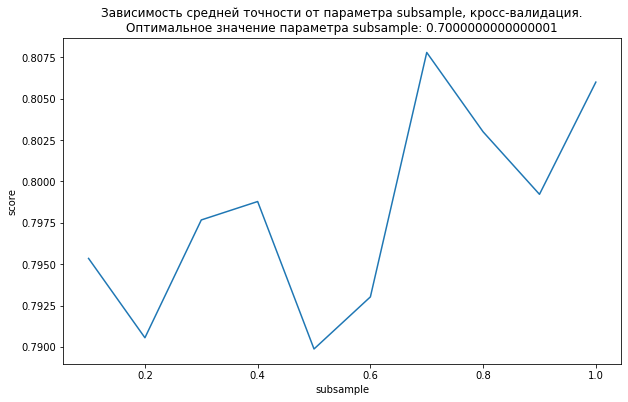

In [129]:
subsample_range = np.arange(0.1, 1.1, 0.1)
opt_subsample = find_opt_param('subsample', subsample_range)
opt_params.update({'subsample': opt_subsample})

Уменьшим learning_rate и найдем оптимальное число итераций (т. е. оптимальное число деревьев, n_estimators)

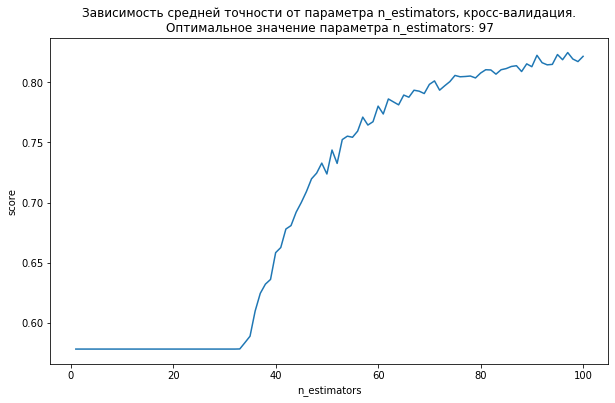

In [136]:
opt_params['learning_rate'] /= 10
opt_params.pop('n_estimators')

n_estimators_range = range(1, 101)
opt_n_estimators = find_opt_param('n_estimators', n_estimators_range)
opt_params.update({'n_estimators': opt_n_estimators})

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [143]:
date = pd.read_csv('./data/Speed Dating Data.csv', encoding='latin1')

date = pd.concat([date.iloc[:, 0], date.iloc[:, 2],
                  date.iloc[:,11:28], date.iloc[:,30:36],
                  date.iloc[:,39:43], date.iloc[:,45:68],
                  date.iloc[:,69:75], date.iloc[:,81:92],
                  date.iloc[:,97:102], date.iloc[:,104:108]], axis=1)
date = date.dropna()

date = date.drop(['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 
                  'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 
                  'music', 'shopping', 'yoga', 'field', 'from', 'career'], axis=1)

X = date.drop(['match'], axis=1).values
y = date['match'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [155]:
def accuracy_with_smart_init(init_model=None):
    my_clf = MyGradientBoostingClassifier(**opt_params)
    my_clf.fit(X_train, y_train, init_model=init_model)

    return accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

def accuracy_with_bagboo(n_boosts=10, init_model=None):
    my_clfs = []

    for _ in tqdm(range(n_boosts)):
        my_clf = MyGradientBoostingClassifier(**opt_params)
        objects, features = my_clf.make_sample(X_train, y_train)
        X_sample = X[np.ix_(objects, features)]
        y_sample = y[objects]
        my_clf.fit(X_sample, y_sample)
        my_clfs.append(my_clf)

    accuracy = np.array([
        accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
        for my_clf in my_clfs
    ]).mean()

    return accuracy

1) BooBag

In [153]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

print('accuracy_score with BooBag: '
      f'{accuracy_with_smart_init(init_model=RandomForestRegressor)}')

accuracy_score with BooBag: 0.9454855195911414


2) BagBoo:

In [156]:
print(f'accuracy_score with BagBoo: {accuracy_with_bagboo()}')


accuracy_score with BagBoo: 0.5153321976149915


3) Объединим подходы

In [157]:
print('accuracy_score with BooBag & BagBoo: '
      f'{accuracy_with_bagboo(init_model=RandomForestRegressor)}')


accuracy_score with BooBag & BagBoo: 0.45042589437819414


### Выводы:
<br/>
- BagBoo незначительно уменьшает точность (в прошлом задании DecisionTreeClassifier давал accuracy около 0.98), однако быстрее работает.
<br/>
- BooBag и, соответственно, его комбинация с BagBoo очень сильно понижает точность.
<br/>
<br/>
Как вариант, причина в недостачно хорошем подборе фичей (довольно много выкинуто), а так же в небольшом объеме выборки (~5000 объектов, на трейн остается еще меньше). 
<br/>
В BooBag базовым моделям приходится обучаться на бутстрапированных выборках из бутстрапированных выборок, а для деревьев из инициализирующего RandomForest, получается, нужно бутстрапировть еще раз. С учетом величины оптимальных процентов на количество объектов и фичей в выборке (subsample & colsample), эти выборки получаются совсем маленькими.
<br/>
Еще точность могла снизиться из-за смещенного распределения таргета: мало матчей, много мисматчей, а бутстрап-выборки не стратифицированы.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [159]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

print('accuracy_score with different init_models:')

models = [LinearRegression, Ridge, Lasso, ElasticNet, 
          RandomForestRegressor, SVR, KNeighborsRegressor]

for model in tqdm(models):
    print(f'{model.__name__}: {accuracy_with_smart_init(init_model=model)}')

accuracy_score with different init_models:


LinearRegression: 1.0
Ridge: 1.0
Lasso: 0.9931856899488927
ElasticNet: 0.9914821124361158
RandomForestRegressor: 0.938671209540034
SVR: 0.8637137989778535
KNeighborsRegressor: 0.899488926746167



### Выводы:
<br/>
- Линейные модели повышают точность, лучше всех справляются LinearRegression и Ridge.
<br/>
- Использование RandomForest в качестве инициализирующей модели равносильно BooBag и описано выше.
<br/>
- SVM и kNN не улучшают точность, а SVM, кроме того, еще и дольше всех работает.
<br/>
<br/>
Такие результаты, предположительно, объясняются линейной зависимостью таргета от параметров.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

